# Jupyter notebook for calculating resistance to flow of TD vessel and valve based on experimental bench data

## 1. Import required libraries and define global variables and functions

In [9]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from lmfit import *
import math
import matplotlib.gridspec as gridspec

In [2]:
# Glabal variables used in multiple cells
markertype= ['o', 's','^','D', '+', '.', '*', '8', 'v']
outputformat = 'png'
dpival = 300

PI = np.pi

def R_poiseuille(D,L,mup): 
    Rp = 128*mup*L/(PI*D**4)
    return Rp

def R2determination(ydata, ymodel):
    residuals = ydata - ymodel
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    return 1-ss_res/ss_tot

print('Libraries have been imported and global variables and functions defined')

Libraries have been imported and global variables and functions defined


## 2. Import bench data

#### Import data of pressure-diameter-flow measurements from Excel file into pandas dataframes

In [3]:
datafile = 'bench_data.xlsx' #location of the data file to be changed as needed
xls = pd.ExcelFile(datafile)
sheetnames = xls.sheet_names
mydictdata = {}
for sheet in sheetnames: #import each sheet from the data file as pandas dataframe and save them in a dictionary
    df = pd.read_excel(datafile, sheet_name = sheet)
    df = df.replace(np.nan, '', regex=True) #remove all NaN (usually empty cells)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')] #remove unamed column that are imported
    mydictdata[sheet] = df

TDnames = sheetnames
TDnames = [e for e in TDnames if e not in ('Phantom', 'Study constants')] #List of TD names

print('Data has been imported into dataframes')

Data has been imported into dataframes


#### Define problem constants

In [4]:
mu_saline_poise = 0.007 #viscosity of 0.9% saline in Poise  1P = 0.1 Pa.s
Poise_to_Pa_s = 0.1
Pa_to_cmH2O = 0.0101972
s_to_min = 1./60
mu_saline = mu_saline_poise*Poise_to_Pa_s*Pa_to_cmH2O*s_to_min #viscosity in cmH2O.min

print('Constants have been defined')

Constants have been defined


#### Calculate average flow and diameter over all TD segments along with standard error

In [5]:
# Calculate pressure gradient across the setup
count = -1
for sheet in TDnames:
    count += 1
    dfTD = mydictdata[sheet]
    dfTD['Pressure gradient total (cmH2O)'] = dfTD['Inlet pressure (cmH2O)'] - dfTD['Outlet pressure (cmH2O)']
    mydictdata[sheet] = dfTD

# Calculate average flow over all TD segments    
count = -1
dfTD_avg = pd.DataFrame()
for sheet in TDnames:
    count += 1
    dfTD = mydictdata[sheet]
    if count == 0:
        dfTD_avg['Pressure gradient total (cmH2O)'] = dfTD['Pressure gradient total (cmH2O)']  
    dfTD_avg[sheet] = dfTD['Flow (ml/min)']
#Average   
dfTD_avg['Average (ml/min)'] = dfTD_avg.drop(['Pressure gradient total (cmH2O)'], axis=1).mean(axis=1)
dfTD_avg['Standard error (ml/min)'] = dfTD_avg.drop(['Pressure gradient total (cmH2O)'], axis=1).std(ddof=0,axis=1)/np.sqrt(len(TDnames))
mydictdata['Average flow'] = dfTD_avg

# Calculate average diameter over all TD segments   
count = -1
dfTD_avg = pd.DataFrame()
for sheet in TDnames:
    count += 1
    dfTD = mydictdata[sheet]
    if count == 0:
        dfTD_avg['Pressure gradient total (cmH2O)'] = dfTD['Pressure gradient total (cmH2O)']  
    dfTD_avg[sheet] = dfTD['Outer diameter (mm)']
#Average   
dfTD_avg['Average (mm)'] = dfTD_avg.drop(['Pressure gradient total (cmH2O)'], axis=1).mean(axis=1)
dfTD_avg['Standard error (mm)'] = dfTD_avg.drop(['Pressure gradient total (cmH2O)'], axis=1).std(ddof=0,axis=1)/np.sqrt(len(TDnames))
mydictdata['Average diameter'] = dfTD_avg

print('Average flow and diameter have been calculated and saved in dataframes along with standard errors')

Average flow and diameter have been calculated and saved in dataframes along with standard errors


## 3. Total resistance of the setup

#### Calculate total resistance of the setup from experiemental data

In [6]:
count = -1
for sheet in TDnames:
    dfTD = mydictdata[sheet]
    mylabel = sheet
    dfTD['Resistance total (cmH2O/(ml/min))'] = dfTD['Pressure gradient total (cmH2O)']/dfTD['Flow (ml/min)']
    mydictdata[sheet] = dfTD 
    
print('Total resistance of the setup has been calculated for each TD segment')

Total resistance of the setup has been calculated for each TD segment


#### Calculate average total resistance of the setup over all TD segment along with standard error

In [7]:
count = -1
dfTD_avg = pd.DataFrame()
for sheet in TDnames:
    count += 1
    dfTD = mydictdata[sheet]
    if count == 0:
        dfTD_avg['Pressure gradient total (cmH2O)'] = dfTD['Pressure gradient total (cmH2O)'] 
    dfTD_avg[sheet] = dfTD['Resistance total (cmH2O/(ml/min))']
#Average total resistance  
dfTD_avg['Average (cmH2O/(ml/min))'] = dfTD_avg.drop(['Pressure gradient total (cmH2O)'], axis=1).mean(axis=1)
dfTD_avg['Standard error (cmH2O/(ml/min))'] = dfTD_avg.drop(['Pressure gradient total (cmH2O)'], axis=1).std(ddof=0,axis=1)/np.sqrt(len(TDnames))
mydictdata['Average resistance total'] = dfTD_avg

print('Average total resistance of the setup over all TD segments has been calculated')

Average total resistance of the setup over all TD segments has been calculated


#### Plot flow, TD diameter, and total resistance of setup vs total pressure gradient accross the setup

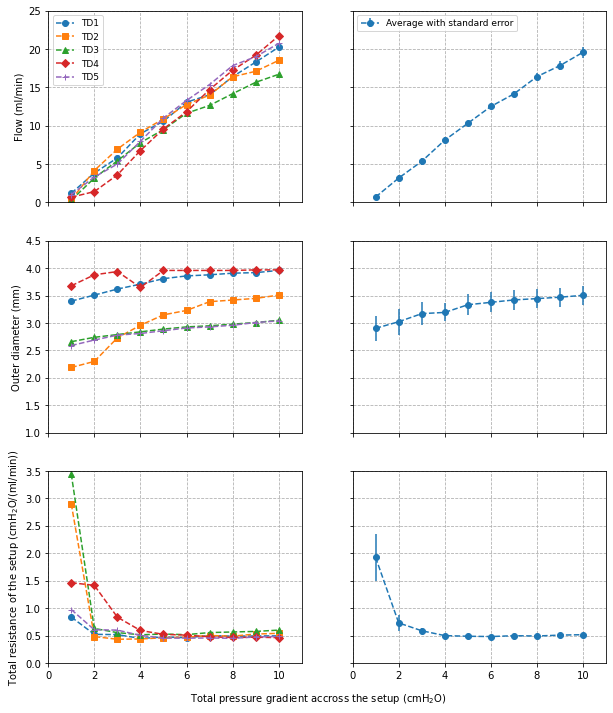

In [11]:
nrow = 3
ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(10,12))


#############################
#1 Flow vs pressure all TD
ax = axs[0][0]

xlabeltext = 'Total pressure gradient accross the setup ($\mathregular{cmH_2O}$)'
ylabeltext = 'Flow (ml/min)'
legendposition = 'upper left'
xvallabel = 'Pressure gradient total (cmH2O)'
yvallabel = 'Flow (ml/min)'
xaxismin = 0
xaxismax = 11
yaxismin = 0
yaxismax = 25

count = -1
for sheet in TDnames:
    count += 1
    dfTD = mydictdata[sheet]
    mylabel = sheet
    ax.plot(dfTD[xvallabel], dfTD[yvallabel], '--', marker=markertype[count],
                     label = mylabel)

#legend
ax.legend(loc = legendposition , fontsize = 9) 

# axis labels
#ax.set_xlabel(xlabeltext, color='k')
ax.set_ylabel(ylabeltext, color='k')

# axis limits
ax.set_xlim(xaxismin, xaxismax)
ax.set_ylim(yaxismin, yaxismax)

#grid
ax.grid(linestyle= '--')

#hide xticks label
ax.tick_params(labelbottom=False) 

#############################
#2 Average flow vs pressure with standard error
ax = axs[0][1]

dfTD_avg = mydictdata['Average flow']
ax.errorbar(dfTD_avg[xvallabel], dfTD_avg['Average (ml/min)'], dfTD_avg['Standard error (ml/min)'], linestyle = '--', marker=markertype[0],
                     label = 'Average with standard error')
#legend
ax.legend(loc = legendposition , fontsize = 9) 

# axis labels
#ax.set_xlabel(xlabeltext, color='k')
#ax.set_ylabel(ylabeltext, color='k')

# axis limits
ax.set_xlim(xaxismin, xaxismax)
ax.set_ylim(yaxismin, yaxismax)

#grid
ax.grid(linestyle= '--')

# Clean organization of subplots
plt.tight_layout

#hide xticks and yticks label
ax.tick_params(labelbottom=False)
ax.tick_params(labelleft=False)

#############################
#3 Outer diameter vs pressure all TD
ax = axs[1][0]

xlabeltext = 'Total pressure gradient accross the setup ($\mathregular{cmH_2O}$)'
ylabeltext = 'Outer diameter (mm)'
legendposition = 'lower right'
yvallabel = 'Outer diameter (mm)'
xaxismin = 0
xaxismax = 11
yaxismin = 1
yaxismax = 4.5

count = -1
for sheet in TDnames:
    count += 1
    dfTD = mydictdata[sheet]
    mylabel = sheet
    ax.plot(dfTD[xvallabel], dfTD[yvallabel], '--', marker=markertype[count],
                     label = mylabel)

#legend
#ax.legend(loc = legendposition , fontsize = 9) 

# axis labels
#ax.set_xlabel(xlabeltext, color='k')
ax.set_ylabel(ylabeltext, color='k')

# axis limits
ax.set_xlim(xaxismin, xaxismax)
ax.set_ylim(yaxismin, yaxismax)

#grid
ax.grid(linestyle= '--')

#hide xticks label
ax.tick_params(labelbottom=False) 

#############################
#4 Average diameter vs pressure with standard error
ax = axs[1][1]

dfTD_avg = mydictdata['Average diameter']
ax.errorbar(dfTD_avg[xvallabel], dfTD_avg['Average (mm)'], dfTD_avg['Standard error (mm)'], linestyle = '--', marker=markertype[0],
                     label = 'Average with standard error')

#legend
#ax.legend(loc = legendposition , fontsize = 9) 

# axis labels
#ax.set_xlabel(xlabeltext, color='k')
#ax.set_ylabel(ylabeltext, color='k')

# axis limits
ax.set_xlim(xaxismin, xaxismax)
ax.set_ylim(yaxismin, yaxismax)

#grid
ax.grid(linestyle= '--')

#hide xticks and yticks label
ax.tick_params(labelbottom=False)
ax.tick_params(labelleft=False)

#############################
#5 Total resistance vs pressure all TD
ax = axs[2][0]

xlabeltext = 'Total pressure gradient accross the setup ($\mathregular{cmH_2O}$)'
ylabeltext = 'Total resistance of the setup ($\mathregular{cmH_2O/(ml/min)}$)'
legendposition = 'upper right'
yvallabel = 'Resistance total (cmH2O/(ml/min))'
xaxismin = 0
xaxismax = 11
yaxismin = 0
yaxismax = 3.5

count = -1
for sheet in TDnames:
    count += 1
    dfTD = mydictdata[sheet]
    mylabel = sheet
    ax.plot(dfTD[xvallabel], dfTD[yvallabel], '--', marker=markertype[count],
                     label = mylabel)

#legend
#ax.legend(loc = legendposition , fontsize = 9) 

# axis labels
#ax.set_xlabel(xlabeltext, color='k')
ax.set_ylabel(ylabeltext, color='k')

# axis limits
ax.set_xlim(xaxismin, xaxismax)
ax.set_ylim(yaxismin, yaxismax)

#grid
ax.grid(linestyle= '--')

#############################
#6 Average total resistance vs pressure with standard error
ax = axs[2][1]

dfTD_avg = mydictdata['Average resistance total']
ax.errorbar(dfTD_avg[xvallabel], dfTD_avg['Average (cmH2O/(ml/min))'], dfTD_avg['Standard error (cmH2O/(ml/min))'], linestyle = '--', marker=markertype[0],
                     label = 'Average with standard error')
#legend
#ax.legend(loc = legendposition , fontsize = 9) 

# axis labels
#ax.set_xlabel(xlabeltext, color='k')
#ax.set_ylabel(ylabeltext, color='k')

# axis limits
ax.set_xlim(xaxismin, xaxismax)
ax.set_ylim(yaxismin, yaxismax)

#grid
ax.grid(linestyle= '--')

#hide xticks label
ax.tick_params(labelleft=False)

#############################

fig.text(0.5, 0.08, xlabeltext, ha='center')


# Clean organization of subplots
plt.tight_layout

#save
savefoldername = "output"
savefilename = 'flow_diameter_resitancetotal-pressure_gradient_total'
savefile = os.path.join(savefoldername, savefilename + '.' +  outputformat)
plt.savefig(savefile, format = outputformat, dpi=dpival, bbox_inches='tight')

## 4. Resistance of the connectors and tubing

#### Calculate resistance to flow Rconn of the connectors and tubing using data collected with the rigid phantom tube. 

#### First, calculate the resistance Rtube of the phantom tube using Poiseuille's law

In [12]:
dfphantom = mydictdata['Phantom']
Dtube = dfphantom['Diameter (mm)'].iloc[0]*0.1 #mm to cm
Ltube = dfphantom['Length (mm)'].iloc[0]*0.1 #mm to cm
Rtube = R_poiseuille(Dtube, Ltube, mu_saline)
print("Rtube is", '{:0.2e}'.format(Rtube), "cmH20/(ml/min)")

Rtube is 1.86e-03 cmH20/(ml/min)


#### Then calculate the total resistance of the setup as the correlation coefficient of the linear interpolation of the presure-flow curve

In [13]:
dfphantom['Pressure gradient total (cmH2O)'] = dfphantom['Inlet pressure (cmH2O)'] - dfphantom['Outlet pressure (cmH2O)']
deltaPtotal = dfphantom['Pressure gradient total (cmH2O)'].values
flow = dfphantom['Flow (ml/min)'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(flow,deltaPtotal) #r-value represents the Pearson's coefficient of correlation, p-value is the two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic
Rsetup = slope
dfphantom['Pressure gradient total model (cmH2O)'] = dfphantom['Flow (ml/min)']*Rsetup
mydictdata['Phantom'] = dfphantom
R2phantom = R2determination(dfphantom['Pressure gradient total (cmH2O)'], dfphantom['Pressure gradient total model (cmH2O)'])
print("Rsetup is", '{:0.2e}'.format(Rsetup), "cmH20/(ml/min)")
print('R2 for the correlation between experimental and model estimated pressure gradient is', round(R2phantom,3))

Rsetup is 3.95e-01 cmH20/(ml/min)
R2 for the correlation between experimental and model estimated pressure gradient is 0.992


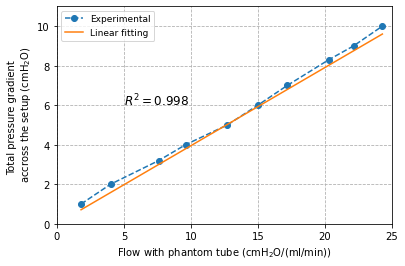

In [16]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)

xlabeltext = 'Flow with phantom tube ($\mathregular{cmH_2O/(ml/min)}$)'
ylabeltext = 'Total pressure gradient \n accross the setup ($\mathregular{cmH_2O}$)'
legendposition = 'upper left'

ax1.plot(dfphantom['Flow (ml/min)'], dfphantom['Pressure gradient total (cmH2O)'], '--', marker=markertype[0], label = "Experimental")
ax1.plot(dfphantom['Flow (ml/min)'], dfphantom['Flow (ml/min)']*Rsetup, label = "Linear fitting")

#legend
ax1.legend(loc = legendposition , fontsize = 9) 

# axis labels
ax1.set_xlabel(xlabeltext, color='k')
ax1.set_ylabel(ylabeltext, color='k')

# axis limits
ax1.set_xlim(0, 25)
ax1.set_ylim(0, 11)

#grid
plt.grid(linestyle= '--')

# R2 value
ax1.text(5,6, '$R^2 = %.3f}$' % r_value**2, fontsize=12)

#save
savefoldername = "output"
savefilename = 'flow-total_pressure_gradient_phantom_setup'
savefile = os.path.join(savefoldername, savefilename + '.' +  outputformat)
plt.savefig(savefile, format = outputformat, dpi=dpival, bbox_inches='tight')

#### Finally, Rconn is simply the difference between Rsetup and Rtube

In [17]:
Rconn = Rsetup - Rtube
print("Rconn is", '{:0.2e}'.format(Rconn), "cmH20/(ml/min)")
for sheet in TDnames:
    dfTD = mydictdata[sheet]
    dfTD['Resistance connectors (cmH2O/(ml/min))'] = Rconn
    dfTD['Pressure drop connectors (cmH2O)'] = Rconn*dfTD['Flow (ml/min)']
    mydictdata[sheet] = dfTD

Rconn is 3.93e-01 cmH20/(ml/min)


## 5. Resistance of the TD vessel

#### Calculate resistance to flow of the vessel for each TD using Poiseuille's law after calculating the inner vessel diameter for each pressure assuming constant thickness

In [18]:
for sheet in TDnames:
    dfTD = mydictdata[sheet] 
    Lvessel = dfTD.iloc[0]['Unloaded length (mm)'] * dfTD.iloc[0]['Loaded stretch ratio']*0.1 #mm to cm
    tvessel = dfTD.iloc[0]['Unloaded thickness (mm)']*0.1 #mm to cm
    outerDvessel = dfTD['Outer diameter (mm)'].values*0.1 #mm to cm
    innerDvessel = outerDvessel - tvessel
    Rvessel = []
    for innerD in innerDvessel:
        Rvessel.append(R_poiseuille(innerD,Lvessel,mu_saline))
 
    dfTD['Resistance vessel (cmH2O/(ml/min))'] = Rvessel
    mydictdata[sheet] = dfTD

print("Resisance to flow of the vessel has been calculated for each TD segment")

Resisance to flow of the vessel has been calculated for each TD segment


#### Calculate average vessel resistance over all TD segment along with standard error

In [19]:
count = -1
dfTD_avg = pd.DataFrame()
for sheet in TDnames:
    count += 1
    dfTD = mydictdata[sheet]
    if count == 0:
        dfTD_avg['Pressure gradient total (cmH2O)'] = dfTD['Pressure gradient total (cmH2O)'] 
    dfTD_avg[sheet] = dfTD['Resistance vessel (cmH2O/(ml/min))']
#Average total resistance  
dfTD_avg['Average (cmH2O/(ml/min))'] = dfTD_avg.drop(['Pressure gradient total (cmH2O)'], axis=1).mean(axis=1)
dfTD_avg['Standard error (cmH2O/(ml/min))'] = dfTD_avg.drop(['Pressure gradient total (cmH2O)'], axis=1).std(ddof=0,axis=1)/np.sqrt(len(TDnames))
mydictdata['Average resistance vessel'] = dfTD_avg

print("Average resistance to flow of the vessel over all TD segments has been calculated ")

Average resistance to flow of the vessel over all TD segments has been calculated 


## 6. Resistance of the valve

#### Calculate the valve resistance by sustracting vessel and connectors resistances from the total resistance of the setup 

In [20]:
for sheet in TDnames:
    dfTD = mydictdata[sheet] 
    dfTD['Resistance valve (cmH2O/(ml/min))'] = dfTD['Resistance total (cmH2O/(ml/min))'] \
    - dfTD['Resistance vessel (cmH2O/(ml/min))'] \
    - dfTD['Resistance connectors (cmH2O/(ml/min))']
    mydictdata[sheet] = dfTD
    
print("Resisance to flow of the valve has been calculated for each TD segment")

Resisance to flow of the valve has been calculated for each TD segment


#### Calculate average valve resistance over all TD segment along with standard error

In [21]:
count = -1
dfTD_avg = pd.DataFrame()
for sheet in TDnames:
    count += 1
    dfTD = mydictdata[sheet]
    if count == 0:
        dfTD_avg['Pressure gradient total (cmH2O)'] = dfTD['Pressure gradient total (cmH2O)'] 
    dfTD_avg[sheet] = dfTD['Resistance valve (cmH2O/(ml/min))']
#Average total resistance  
dfTD_avg['Average (cmH2O/(ml/min))'] = dfTD_avg.drop(['Pressure gradient total (cmH2O)'], axis=1).mean(axis=1)
dfTD_avg['Standard error (cmH2O/(ml/min))'] = dfTD_avg.drop(['Pressure gradient total (cmH2O)'], axis=1).std(ddof=0,axis=1)/np.sqrt(len(TDnames))
mydictdata['Average resistance valve'] = dfTD_avg

print("Average resistance to flow of the valve over all TD segments has been calculated ")

Average resistance to flow of the valve over all TD segments has been calculated 


#### Plot of vessel and valve resistances vs total pressure drop

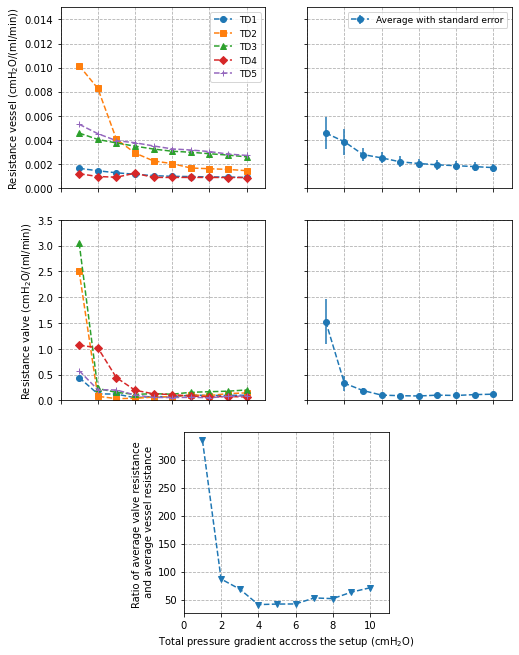

In [24]:
nrow = 2
ncol = 2
fig = plt.figure(figsize=(7,9))
gs = gridspec.GridSpec(3, 4)
ax1 = plt.subplot(gs[0, 0:2])
ax2 = plt.subplot(gs[0,2:])
ax3 = plt.subplot(gs[1,0:2])
ax4 = plt.subplot(gs[1,2:])
ax5 = plt.subplot(gs[2,1:3])
gs.tight_layout(fig)
axs = [ax1,ax2,ax3,ax4,ax5]
fig.autolayout : True
savefilename = 'vessel_valve_resitances-pressure_gradient_total'

#############################
#1 Vessel resistance vs pressure all TD
ax = axs[0]

xlabeltext = 'Total pressure gradient accross the setup ($\mathregular{cmH_2O}$)'
ylabeltext = 'Resistance vessel ($\mathregular{cmH_2O/(ml/min)}$)'
legendposition = 'upper right'
xvallabel = 'Pressure gradient total (cmH2O)'
yvallabel = 'Resistance vessel (cmH2O/(ml/min))'
xaxismin = 0
xaxismax = 11
yaxismin = 0
yaxismax = 0.015

count = -1
for sheet in TDnames:
    count += 1
    dfTD = mydictdata[sheet]
    mylabel = sheet
    ax.plot(dfTD[xvallabel], dfTD[yvallabel], '--', marker=markertype[count],
                     label = mylabel)

#legend
ax.legend(loc = legendposition , fontsize = 9) 

# axis labels
#ax.set_xlabel(xlabeltext, color='k')
ax.set_ylabel(ylabeltext, color='k')

# axis limits
ax.set_xlim(xaxismin, xaxismax)
ax.set_ylim(yaxismin, yaxismax)

#grid
ax.grid(linestyle= '--')

#hide ticks label
ax.tick_params(labelbottom=False)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#############################
#2  Average vessel resistance with standard error
ax = axs[1]

dfTD_avg = mydictdata['Average resistance vessel']
ax.errorbar(dfTD_avg[xvallabel], dfTD_avg['Average (cmH2O/(ml/min))'], dfTD_avg['Standard error (cmH2O/(ml/min))'], linestyle = '--', marker=markertype[0],
                     label = 'Average with standard error')

#legend
ax.legend(loc = legendposition , fontsize = 9) 

# axis labels
#ax.set_xlabel(xlabeltext, color='k')
#ax.set_ylabel(ylabeltext, color='k')

# axis limits
ax.set_xlim(xaxismin, xaxismax)
ax.set_ylim(yaxismin, yaxismax)

#grid
ax.grid(linestyle= '--')

#hide xticks and yticks label
ax.tick_params(labelbottom=False)
ax.tick_params(labelleft=False)

#############################
#3 Valve resistance vs pressure all TD
ax = axs[2]

xlabeltext = 'Total pressure gradient accross the setup ($\mathregular{cmH_2O}$)'
ylabeltext = 'Resistance valve ($\mathregular{cmH_2O/(ml/min)}$)'
legendposition = 'upper left'
yvallabel = 'Resistance valve (cmH2O/(ml/min))'
xaxismin = 0
xaxismax = 11
yaxismin = 0
yaxismax = 3.5

count = -1
for sheet in TDnames:
    count += 1
    dfTD = mydictdata[sheet]
    mylabel = sheet
    ax.plot(dfTD[xvallabel], dfTD[yvallabel], '--', marker=markertype[count],
                     label = mylabel)

#legend
#ax.legend(loc = legendposition , fontsize = 9) 

# axis labels
#ax.set_xlabel(xlabeltext, color='k')
ax.set_ylabel(ylabeltext, color='k')

# axis limits
ax.set_xlim(xaxismin, xaxismax)
ax.set_ylim(yaxismin, yaxismax)

#grid
ax.grid(linestyle= '--')

#hide xticks label
ax.tick_params(labelbottom=False)

#############################
#4 Average valve resistance with standard error
ax = axs[3]

dfTD_avg = mydictdata['Average resistance valve']
ax.errorbar(dfTD_avg[xvallabel], dfTD_avg['Average (cmH2O/(ml/min))'], dfTD_avg['Standard error (cmH2O/(ml/min))'], linestyle = '--', marker=markertype[0],
                     label = 'Average with standard error')
#legend
#ax.legend(loc = legendposition , fontsize = 9) 

# axis labels
#ax.set_xlabel(xlabeltext, color='k')
#ax.set_ylabel(ylabeltext, color='k')

# axis limits
ax.set_xlim(xaxismin, xaxismax)
ax.set_ylim(yaxismin, yaxismax)

#grid
ax.grid(linestyle= '--')

#hide xticks and yticks label
ax.tick_params(labelbottom=False)
ax.tick_params(labelleft=False)

#############################
#5 Ratio between average valve resistance and average vessel resistance vs pressure 
ax = axs[4]
ylabeltext = 'Ratio of average valve resistance \n and average vessel resistance'

dfTD_avg_valve = mydictdata['Average resistance valve']
dfTD_avg_vessel = mydictdata['Average resistance vessel']
count = -1
ax.plot(dfTD_avg_valve[xvallabel], dfTD_avg_valve['Average (cmH2O/(ml/min))']/dfTD_avg_vessel['Average (cmH2O/(ml/min))'], '--', marker=markertype[count],
                    label = mylabel)
#legend
#ax.legend(loc = legendposition , fontsize = 9) 

# axis labels
ax.set_xlabel(xlabeltext, color='k')
ax.set_ylabel(ylabeltext, color='k')

# axis limits
ax.set_xlim(xaxismin, xaxismax)
#ax.set_ylim(yaxismin, yaxismax)

#grid
ax.grid(linestyle= '--')

#print(dfTD_avg_valve['Average (cmH2O/(ml/min))'],  dfTD_avg_vessel['Average (cmH2O/(ml/min))'], dfTD_avg_valve['Average (cmH2O/(ml/min))']/dfTD_avg_vessel['Average (cmH2O/(ml/min))'])

#############################
# Clean organization of subplots
plt.tight_layout

#save
savefoldername = "output"
savefile = os.path.join(savefoldername, savefilename + '.' +  outputformat)
plt.savefig(savefile, format = outputformat, dpi=dpival, bbox_inches='tight')

## 7. Model of the valve resistance

#### Reavaluate pressure gradient in the valve such that it increases as total pressure gradient in the setup increases (for consistency)

In [25]:
def Rfitfunc_deltaP(dp, P0, Ap):
    return P0 * np.exp(Ap * dp)

def fcntomin_P(params, x, data):
    P0 = params['P0']
    Ap = params['Ap']
    model = []
    for dp in x:
        model.append(Rfitfunc_deltaP(dp, P0, Ap))
    return (model - data)

for sheet in TDnames:
    dfTD = mydictdata[sheet]
    dfTD['Pressure gradient valve (cmH2O)'] = dfTD['Pressure gradient total (cmH2O)'] - \
    (dfTD['Resistance connectors (cmH2O/(ml/min))'] + dfTD['Resistance vessel (cmH2O/(ml/min))'])*dfTD['Flow (ml/min)']
    params = Parameters()
    params.add('P0', value = 0.1)
    params.add('Ap', value = -1)
    x = dfTD['Pressure gradient total (cmH2O)'].values
    data = dfTD['Pressure gradient valve (cmH2O)'].values
    result = minimize(fcntomin_P, params, args=(x,), kws={'data':data}, method = 'nelder')
    final = data + result.residual
    dfTD['Pressure gradient valve model (cmH2O)'] =  final
    mydictdata[sheet] = dfTD

print("Pressure gradient across the valve has been reevaluated for each TD segment")

Pressure gradient across the valve has been reevaluated for each TD segment


#### Plot the results for TD1

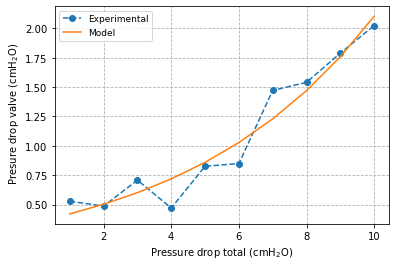

In [26]:
fig1 = plt.figure(figsize=(6,4))
ax1 = fig1.add_subplot(1,1,1)
legendposition = 'upper left'

ylabeltext = ' Presure drop valve ($\mathregular{cmH_2O}$)'
xlabeltext1 = 'Pressure drop total ($\mathregular{cmH_2O}$)'

sheet = 'TD1'
dfTD = mydictdata[sheet]
count = 0
ax1.plot(dfTD['Pressure gradient total (cmH2O)'], dfTD['Pressure gradient valve (cmH2O)'], '--', marker=markertype[count],
         label = 'Experimental')
ax1.plot(dfTD['Pressure gradient total (cmH2O)'], dfTD['Pressure gradient valve model (cmH2O)'],
         label = 'Model')

#legend
ax1.legend(loc = legendposition , fontsize = 9) 

# axis labels
ax1.set_xlabel(xlabeltext1, color='k')
ax1.set_ylabel(ylabeltext, color='k')

# axis limits
#ax1.set_xlim(0, 11)

#grid
plt.grid(linestyle= '--')

#### Model fitting to the valve resistance behavior

In [27]:
def Rfitfunc(dp, Rvl, Rvh, s):
    return Rvl + Rvh/(1+np.exp(s*dp))

def fcntomin(params, x, data):
    Rvl = params['Rvl']
    Rvh = params['Rvh']
    s = params['s']
    model = []
    for dp in x:
        model.append(Rfitfunc(dp, Rvl, Rvh, s))
    return (model - data)    
    
R2valve = [] 
dfparams = pd.DataFrame()
dfparams['TD #'] = [1, 2, 3, 4, 5]
Rvlvect =[]
Rvhvect =[]
svect =[]
for sheet in TDnames:
    dfTD = mydictdata[sheet]
    Rvalvefitting = dfTD['Resistance valve (cmH2O/(ml/min))']
    Pvalvefitting = dfTD['Pressure gradient valve model (cmH2O)']
    params = Parameters()
    params.add('Rvl', min = 0.001, value = 0.1)
    params.add('Rvh', min = 0.001, value = 1)
    params.add('s', value = 1)
    x = dfTD['Pressure gradient valve model (cmH2O)'].values
    data = dfTD['Resistance valve (cmH2O/(ml/min))'].values 
    result = minimize(fcntomin, params, args=(x,), kws={'data':data}, method = 'nelder')
    final = data + result.residual
    R2valve.append(R2determination(data, final))
    Rvalvemodel = final
    dfTD['Resistance valve model (cmH2O/(ml/min))'] =  Rvalvemodel
    mydictdata[sheet] = dfTD
    Rvlvect.append(round(result.params['Rvl'].value,3))
    Rvhvect.append(round(result.params['Rvh'].value,3))
    svect.append(round(result.params['s'].value,1))
dfparams['Rvl (cmH20/(ml/min))'] = Rvlvect
dfparams['Rvh (cmH20/(ml/min))'] = Rvhvect
dfparams['s'] = svect
print('Average R2 for the correlation between experiemental and model estimated valve resistance is', round(np.mean(R2valve),3))
print('with a standard deviation of', round(np.std(R2valve),3))
display(dfparams)

Average R2 for the correlation between experiemental and model estimated valve resistance is 0.971
with a standard deviation of 0.027


,TD #,Rvl (cmH20/(ml/min)),Rvh (cmH20/(ml/min)),s
0,1,0.088,1.538968e+04,25.4
1,2,0.085,1.787685e+11,89.5
2,3,0.154,6.328735e+07,28.5
3,4,0.011,7.384351e+09,19.0
4,5,0.071,9.093890e+02,14.5


#### Plot of experimental and model fitted valve resistance vs pressure gradient across the valve

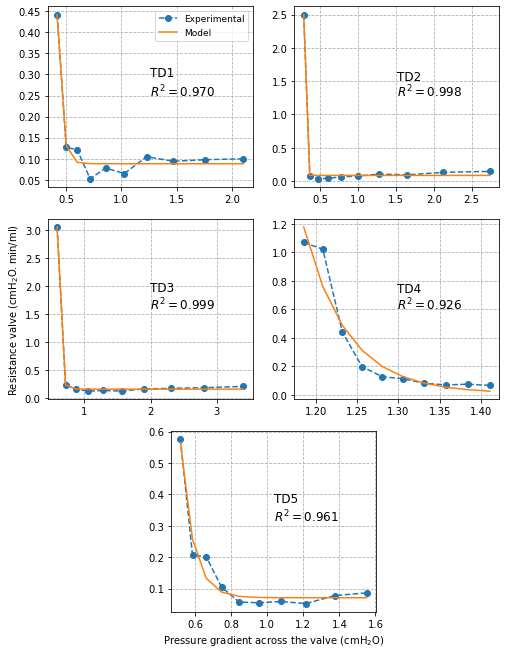

In [30]:
fig = plt.figure(figsize=(7,9))
gs = gridspec.GridSpec(3, 4)
ax1 = plt.subplot(gs[0, 0:2])
ax2 = plt.subplot(gs[0,2:])
ax3 = plt.subplot(gs[1,0:2])
ax4 = plt.subplot(gs[1,2:])
ax5 = plt.subplot(gs[2,1:3])
gs.tight_layout(fig)
axs = [ax1,ax2,ax3,ax4,ax5]
fig.autolayout : True
legendposition = 'upper right'
ylabeltext = 'Resistance valve ($\mathregular{cmH_2O.min/ml}$)'
xlabeltext = 'Pressure gradient across the valve ($\mathregular{cmH_2O}$)'

count = 0
for i, ax in enumerate(fig.axes):
    sheet = TDnames[i]
    dfTD = mydictdata[sheet]

    ax.plot(dfTD['Pressure gradient valve model (cmH2O)'], dfTD['Resistance valve (cmH2O/(ml/min))'], '--', marker=markertype[count],
             label = 'Experimental')
    ax.plot(dfTD['Pressure gradient valve model (cmH2O)'], dfTD['Resistance valve model (cmH2O/(ml/min))'],
             label = 'Model')
    #legend
    if i == 0:
        ax.legend(loc = legendposition , fontsize = 9) 

    # axis labels
    if i == 4:
        ax.set_xlabel(xlabeltext, color='k')
    if i == 2:
        ax.set_ylabel(ylabeltext, color='k')

    #grid
    ax.grid(linestyle= '--')
    
    # R2 value
    xaxismid = np.mean(ax.get_xlim())
    yaxismid = np.mean(ax.get_ylim())
    ax.text(xaxismid, yaxismid, '$R^2 = %.3f}$' % R2valve[i], fontsize=12)
    ax.text(xaxismid, yaxismid*1.2, sheet, fontsize=12)

# Clean organization of subplots
plt.tight_layout

plt.subplots_adjust(bottom=0.3) 

#save
savefoldername = "output"
savefilename = 'resistance_valve_model-valve_pressure_gradient'
savefile = os.path.join(savefoldername, savefilename + '.' +  outputformat)
plt.savefig(savefile, format = outputformat, dpi=dpival, bbox_inches='tight')

## 7. Validation of the model with flow prediction

#### Calculate model predicted flow 

In [31]:
R2flow = []
for sheet in TDnames:
    dfTD = mydictdata[sheet]
    dfTD['Flow model (ml/min)'] = dfTD['Pressure gradient total (cmH2O)'] \
    /(dfTD['Resistance connectors (cmH2O/(ml/min))'] + dfTD['Resistance vessel (cmH2O/(ml/min))'] + dfTD['Resistance valve model (cmH2O/(ml/min))'])
    R2flow.append(R2determination(dfTD['Flow (ml/min)'], dfTD['Flow model (ml/min)']))
    mydictdata[sheet] = dfTD
print('Average R2 for the correlation between experiemental and model estimated flow is', round(np.mean(R2flow),3))
print('with a standard deviation of', round(np.std(R2flow),3))

Average R2 for the correlation between experiemental and model estimated flow is 0.985
with a standard deviation of 0.01


#### Plot pressure vs predicted flow

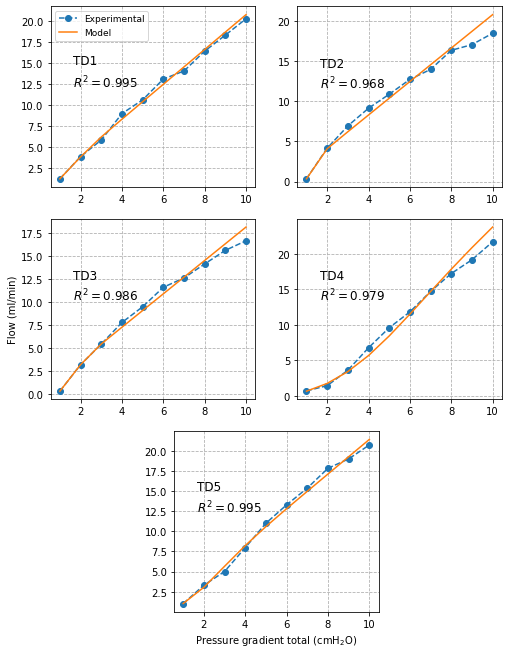

In [32]:
fig = plt.figure(figsize=(7,9))
gs = gridspec.GridSpec(3, 4)
ax1 = plt.subplot(gs[0, 0:2])
ax2 = plt.subplot(gs[0,2:])
ax3 = plt.subplot(gs[1,0:2])
ax4 = plt.subplot(gs[1,2:])
ax5 = plt.subplot(gs[2,1:3])
gs.tight_layout(fig)
axs = [ax1,ax2,ax3,ax4,ax5]
fig.autolayout : True
legendposition = 'upper left'
ylabeltext = 'Flow (ml/min)'
xlabeltext = 'Pressure gradient total ($\mathregular{cmH_2O}$)'

count = 0
for i, ax in enumerate(fig.axes):
    sheet = TDnames[i]
    dfTD = mydictdata[sheet]

    ax.plot(dfTD['Pressure gradient total (cmH2O)'], dfTD['Flow (ml/min)'], '--', marker=markertype[count],
             label = 'Experimental')
    ax.plot(dfTD['Pressure gradient total (cmH2O)'], dfTD['Flow model (ml/min)'],
             label = 'Model')
    #legend
    if i == 0:
        ax.legend(loc = legendposition , fontsize = 9) 

    # axis labels
    if i == 4:
        ax.set_xlabel(xlabeltext, color='k')
    if i == 2:
        ax.set_ylabel(ylabeltext, color='k')

    #grid
    ax.grid(linestyle= '--')
    
    # R2 value
    xaxismid = np.mean(ax.get_xlim())
    yaxismid = np.mean(ax.get_ylim())
    ax.text(xaxismid*0.3, yaxismid*1.1, '$R^2 = %.3f}$' % R2flow[i], fontsize=12)
    ax.text(xaxismid*0.3, yaxismid*1.35, sheet, fontsize=12)
# Clean organization of subplots
plt.tight_layout

plt.subplots_adjust(bottom=0.3) 

#save
savefoldername = "output"
savefilename = 'flow_model-pressure_gradient_total'
savefile = os.path.join(savefoldername, savefilename + '.' +  outputformat)
plt.savefig(savefile, format = outputformat, dpi=dpival, bbox_inches='tight')

## 8. Pressure threshold

In [33]:
deltaPt = []
count = -1
for sheet in TDnames:
    count += 1
    Rvl = dfparams['Rvl (cmH20/(ml/min))'].iloc[count]
    Rvh = dfparams['Rvh (cmH20/(ml/min))'].iloc[count]
    s = dfparams['s'].iloc[count]
    dp = 1/s*np.log(Rvh/(0.05*Rvl))
    deltaPt.append(dp)
    print('The pressure treshold for', sheet, 'is', round(dp,3), 'cmH2O')
print('Average pressure treshold is', round(np.mean(deltaPt),3))
print('with a standard deviation of', round(np.std(deltaPt),3))

The pressure treshold for TD1 is 0.593 cmH2O
The pressure treshold for TD2 is 0.351 cmH2O
The pressure treshold for TD3 is 0.801 cmH2O
The pressure treshold for TD4 is 1.591 cmH2O
The pressure treshold for TD5 is 0.859 cmH2O
Average pressure treshold is 0.839
with a standard deviation of 0.416
